# ● Libraries

In [47]:
import numpy as np
import csv
import cv2
import os
import glob
import matplotlib.pyplot as plt
import math
from scipy import ndimage
from skimage import data
from skimage import filters as skifilters
from skimage import img_as_float
from sklearn.cluster import KMeans, MeanShift
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage.measure import label as skilabel
from skimage.segmentation import (morphological_chan_vese,
                                  checkerboard_level_set)
from skimage.feature import local_binary_pattern
from skimage.feature.texture import greycomatrix, greycoprops
from scipy.stats import skew
from skimage.measure import label, regionprops
from scipy import interp
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import time
import seaborn as sn
import pandas as pd
import time
import tqdm
#import dill
from ReliefF import ReliefF
from skimage.morphology.convex_hull import convex_hull_image

from skimage.color import rgb2hed, rgb2gray

from scipy.spatial import ConvexHull, Voronoi, voronoi_plot_2d, distance
from scipy.stats import entropy as entropy_
from sklearn import preprocessing


# ● Dataset

In [2]:
def sortData(path,mask=False):
    """"
    Input:  path
    Output: data[p] = {
        'id':
        'image':
        'label': }
        
    """
    # Importing Images
    B0_dir  = glob.glob(path+"/b0/*.png")
    M0_dir  = glob.glob(path+"/m0/*.png")

    print("Number of B0 Images:",  len(B0_dir))
    print("Number of M0 Images:",  len(M0_dir))
    
    # Creating Dictionary (B0 Scans)
    data = {}
    for p in range(len(B0_dir)):
        scan_id  =  B0_dir[p].replace(".png", "")
        scan_id  =  scan_id.replace(path+"/b0\\", "")

        # Creating list of dictionary                    
        data[p] = {
                    'id'    : scan_id,
                    'image' : B0_dir[p],
                    'label' : 0 }            # Label of B0 = 0

    # Creating Dictionary (M0 Scans)
    for p in range(len(M0_dir)):
        scan_id  =  M0_dir[p].replace(".png", "")
        scan_id  =  scan_id.replace(path+"/m0\\", "")

        # Creating list of dictionary                    
        data[p+len(M0_dir)] = {
                    'id'    : scan_id,
                    'image' : M0_dir[p],
                    'label' : 1 }            # Label of M0 = 1
    return data

def findScan(data,name,key):
    """"
    Input: 
        data     - dict of dict to sort the data
        key      - key of 'data' ('id','image','label')
        value    - value of 'key'
    Output:
        value
    """
    for i, dic in data.items():
        if dic[key] == name:        
            return i
    return -1

In [3]:
train_data = sortData('train')           # Load Training Set

Number of B0 Images: 13108
Number of M0 Images: 13108


In [4]:
val_data   = sortData('val')             # Load Validation Set

Number of B0 Images: 1639
Number of M0 Images: 1639


In [5]:
# Pass Target Image (Example)
index1  = findScan(train_data,'b_trainImage115','id')
sample1 = plt.imread(train_data[index1]['image'])
index2  = findScan(train_data,'b_trainImage111','id')
sample2 = plt.imread(train_data[index2]['image'])
index3  = findScan(train_data,'b_trainImage140','id')
sample3 = plt.imread(train_data[index3]['image'])

# ● Preprocessing

## Contrast-Limited Adaptive Histogram Equalization (CLAHE)

In [6]:
def clahe_RGB(img,clip=3,tile=1):

    lab        = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)                          # Convert to LAB Color Space
    clahe      = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile,tile))     # Create CLAHE Function
    lab[:,:,0] = clahe.apply(lab[:,:,0])                                       # Apply Transformation
    output     = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)                          # Convert to LAB Color Space
   
    return output

## PDE-ROF Denoising

In [7]:
def denoise_RGB(img, weight=0.1, eps=1e-3, num_iter_max=200):
    op_img = img.copy()
    for channel in range(3):
        u   = np.zeros_like(img[:,:,channel])
        px  = np.zeros_like(img[:,:,channel])
        py  = np.zeros_like(img[:,:,channel])
        nm  = np.prod(img.shape[:2])
        tau = 0.125

        i = 0
        while (i < num_iter_max):
            u_old = u

            # X and Y Components of U's Gradient
            ux = np.roll(u, -1, axis=1) - u
            uy = np.roll(u, -1, axis=0) - u

            # Update Dual Variable
            px_new   = px + (tau / weight) * ux
            py_new   = py + (tau / weight) * uy
            norm_new = np.maximum(1, np.sqrt(px_new **2 + py_new ** 2))
            px       = px_new / norm_new
            py       = py_new / norm_new

            # Calculate Divergence
            rx    = np.roll(px, 1, axis=1)
            ry    = np.roll(py, 1, axis=0)
            div_p = (px - rx) + (py - ry)

            # Update Image
            u = img[:,:,channel] + weight * div_p

            # Calculate Error
            error = np.linalg.norm(u - u_old) / np.sqrt(nm)
            if i == 0:
                err_init = error
                err_prev = error
            else:
                # Break for Small Error
                if np.abs(err_prev - error) < eps * err_init:
                    break
                else:
                    err_prev = error
            i += 1    
            op_img[:,:,channel] = u

    return op_img

# Voronoi

In [9]:
def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            try:
                vol[i] = ConvexHull(v.vertices[indices]).volume
            except:
                vol[i] = 0
    return vol

def find_max_dist(vor, point, array):
    
    all_dist = []
    
    for x in array:
#        print (x)
        all_dist.append(distance.euclidean(vor.ridge_points[point], vor.ridge_points[x]))
        
    return np.max(all_dist)

# ● Feature Extraction

In [10]:
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]


def extract_features(image):
    
     # Color Spaces --------------------------------------------------------------------------------------------------
    img_RGB                 = image
    img_HSV                 = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    img_LAB                 = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Lab)
    img_YCrCb               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    img_GL                  = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    img_luv                 = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Luv)
    
   # -------------------------------------------------------------------------------------------
    
    #  Voronoi  ------------------------------------------------------------------------------------------
    #image_gray = rgb2gray(image)
    
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    blur = cv2.GaussianBlur(image_gray,(3,3),0)

    min_intensity = np.min(blur)
    max_intensity = np.max(blur)

    perc = 0.30

    diff = (max_intensity - min_intensity) * perc

    thresh = blur.copy()
    thresh[thresh > (min_intensity + diff)] = 0

    thresh[thresh > 0] = 1
    
    connectivity = 4
    output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_8S)

    # The fourth cell is the centroid matrix
    centroids = output[3]
    
    if len(centroids) > 3:       

        vor = Voronoi(centroids)

        # get the areas of the regions:-----------------------
        all_area = voronoi_volumes(centroids)

        #remove occurences of 'inf'
        new_all_area = []
        for area in all_area:
            if str(area) != 'inf':
                new_all_area.append(area)



        all_regions = vor.regions

        all_chord_lengths = []

        for region in all_regions:
            no_of_points = len(region)

            if no_of_points == 0 or -1 in region:
                continue

            for point in region:
                all_max_dist = []

                region_copy = region.copy()
                region_copy.remove(point)

                max_dist = find_max_dist(vor, point, region_copy)

                all_max_dist.append(max_dist)

            all_chord_lengths.append(np.max(all_max_dist))



        area_avg = np.mean(new_all_area)
        area_std_dev = np.std(new_all_area)

        if len(new_all_area) == 0:
            area_min_max_ratio = 0

        else:
            area_min_max_ratio = (np.min(new_all_area)/np.max(new_all_area))

        area_entropy = entropy_(new_all_area)



        chord_avg = np.mean(all_chord_lengths)
        chord_std_dev = np.std(all_chord_lengths)

        if len(all_chord_lengths) == 0:
            chord_min_max_ratio = 0
        else:
            chord_min_max_ratio = (np.min(new_all_area)/np.max(new_all_area))

        chord_entropy = entropy_(all_chord_lengths)

    else:
        
        area_avg = area_std_dev = area_min_max_ratio = area_entropy = 0
        chord_avg = chord_std_dev = chord_min_max_ratio = chord_entropy = 0
        

    
   # -----------------------------------------------------------------------------------------------------
    
    
    
   
    '''
    he_image = rgb2hed(img_RGB).astype(int)
    
    img_hema = he_image[:,:,0] + 1
    #img_eosin = he_image[:,:,1] + 1
    img_dab = he_image[:,:,2] + 1
    
    
    #    --------------------------------------
    
    image_gray = rgb2gray(img_RGB)
    
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(image_gray,(3,3),0)
    #plt.imshow(blur, 'gray')
    
    
    min_intensity = np.min(blur)
    max_intensity = np.max(blur)
    
    perc = 0.50
    
    diff = (max_intensity - min_intensity) * perc
    
    thresh = blur.copy()
    thresh[thresh > (min_intensity + diff)] = 0
    
    thresh[thresh > 0] = 1
    
    cropped = image.copy()
    cropped[:,:,0] = img_RGB[:,:,0] * thresh
    cropped[:,:,1] = img_RGB[:,:,1] * thresh
    cropped[:,:,2] = img_RGB[:,:,2] * thresh
    
    #remove occurance of 0
    vect_0 = remove_values_from_list(cropped[:,:,0].ravel(), 0)
    vect_1 = remove_values_from_list(cropped[:,:,1].ravel(), 0)
    vect_2 = remove_values_from_list(cropped[:,:,2].ravel(), 0)
    
    cropped_mean_R = np.mean(vect_0)
    cropped_mean_G = np.mean(vect_1)
    cropped_mean_B = np.mean(vect_2)
    cropped_std_R = np.std(vect_0)
    cropped_std_G = np.std(vect_1)
    cropped_std_B = np.std(vect_2)
    cropped_skew_R = skew(vect_0)
    cropped_skew_G = skew(vect_1)
    cropped_skew_B = skew(vect_2)  
    '''
    #----------------------------------------------------------------------------------------------------------------
    
    
    #----------------------------------------------------------------------------------------------------------------
    
    
    
    # Color Moments -------------------------------------------------------------------------------------------------
    '''mean_hema = np.mean(img_hema)
    #mean_eosin = np.mean(img_eosin)
    mean_dab = np.mean(img_dab)
    std_hema = np.std(img_hema)
    #std_eosin = np.std(img_eosin)
    std_dab = np.std(img_dab)
    skew_hema = skew(img_hema.reshape(-1))
    #skew_eosin = skew(img_eosin.reshape(-1))
    skew_dab = skew(img_dab.reshape(-1))       
    '''
    
    mean_R = np.mean(img_RGB[:,:,0])
    mean_G = np.mean(img_RGB[:,:,1])
    mean_B = np.mean(img_RGB[:,:,2])
    std_R = np.std(img_RGB[:,:,0])
    std_G = np.std(img_RGB[:,:,1])
    std_B = np.std(img_RGB[:,:,2])
    skew_R = skew(img_RGB[:,:,0].reshape(-1))
    skew_G = skew(img_RGB[:,:,1].reshape(-1))
    skew_B = skew(img_RGB[:,:,2].reshape(-1))

    mean_H = np.mean(img_HSV[:,:,0])
    mean_S = np.mean(img_HSV[:,:,1])
    mean_V = np.mean(img_HSV[:,:,2])
    std_H = np.std(img_HSV[:,:,0])
    std_S = np.std(img_HSV[:,:,1])
    std_V = np.std(img_HSV[:,:,2])
    skew_H = skew(img_HSV[:,:,0].reshape(-1))
    skew_S = skew(img_HSV[:,:,1].reshape(-1))
    skew_V = skew(img_HSV[:,:,2].reshape(-1))

    mean_L = np.mean(img_LAB[:,:,0])
    mean_A = np.mean(img_LAB[:,:,1])
    mean_b = np.mean(img_LAB[:,:,2])
    std_L = np.std(img_LAB[:,:,0])
    std_A = np.std(img_LAB[:,:,1])
    std_b = np.std(img_LAB[:,:,2])
    skew_L = skew(img_LAB[:,:,0].reshape(-1))
    skew_A = skew(img_LAB[:,:,1].reshape(-1))
    skew_b = skew(img_LAB[:,:,2].reshape(-1))
    
    mean_Y = np.mean(img_YCrCb[:,:,0])
    mean_Cr = np.mean(img_YCrCb[:,:,1])
    mean_Cb = np.mean(img_YCrCb[:,:,2])
    std_Y = np.std(img_YCrCb[:,:,0])
    std_Cr = np.std(img_YCrCb[:,:,1])
    std_Cb = np.std(img_YCrCb[:,:,2])
    skew_Y = skew(img_YCrCb[:,:,0].reshape(-1))
    skew_Cr = skew(img_YCrCb[:,:,1].reshape(-1))
    skew_Cb = skew(img_YCrCb[:,:,2].reshape(-1))
    
    mean_l = np.mean(img_luv[:,:,0])
    mean_u = np.mean(img_luv[:,:,1])
    mean_v = np.mean(img_luv[:,:,2])
    std_l = np.std(img_luv[:,:,0])
    std_u = np.std(img_luv[:,:,1])
    std_v = np.std(img_luv[:,:,2])
    skew_l = skew(img_luv[:,:,0].reshape(-1))
    skew_u = skew(img_luv[:,:,1].reshape(-1))
    skew_v = skew(img_luv[:,:,2].reshape(-1))
    #--------------------------------------------------------------------------------------------------------------
    
    
    
    # Grey-Level Co-Occurrence Matrix -----------------------------------------------------------------------------
    GLCM_R = greycomatrix(img_RGB[:,:,0], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_G = greycomatrix(img_RGB[:,:,1], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_B = greycomatrix(img_RGB[:,:,2], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_H = greycomatrix(img_HSV[:,:,0], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_S = greycomatrix(img_HSV[:,:,1], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_V = greycomatrix(img_HSV[:,:,2], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_L = greycomatrix(img_LAB[:,:,0], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_a = greycomatrix(img_LAB[:,:,1], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_b = greycomatrix(img_LAB[:,:,2], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    #GLCM_hema = greycomatrix(he_image[:,:,0]+1, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    #GLCM_eosin = greycomatrix(he_image[:,:,1]+1, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    #GLCM_dab = greycomatrix(he_image[:,:,2]+1, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    
    
    contrast_R = greycoprops(GLCM_R, 'contrast').mean()
    contrast_G = greycoprops(GLCM_G, 'contrast').mean()
    contrast_B = greycoprops(GLCM_B, 'contrast').mean()
    contrast_H = greycoprops(GLCM_H, 'contrast').mean()
    contrast_S = greycoprops(GLCM_S, 'contrast').mean()
    contrast_V = greycoprops(GLCM_V, 'contrast').mean()
    contrast_L = greycoprops(GLCM_L, 'contrast').mean()
    contrast_a = greycoprops(GLCM_a, 'contrast').mean()
    contrast_b = greycoprops(GLCM_b, 'contrast').mean()
    #contrast_hema = greycoprops(GLCM_hema, 'contrast').mean()
    #contrast_eosin = greycoprops(GLCM_eosin, 'contrast').mean()
    #contrast_dab = greycoprops(GLCM_dab, 'contrast').mean()

    dissim_R = greycoprops(GLCM_R, 'dissimilarity').mean()
    dissim_G = greycoprops(GLCM_G, 'dissimilarity').mean()
    dissim_B = greycoprops(GLCM_B, 'dissimilarity').mean()
    dissim_H = greycoprops(GLCM_H, 'dissimilarity').mean()
    dissim_S = greycoprops(GLCM_S, 'dissimilarity').mean()
    dissim_V = greycoprops(GLCM_V, 'dissimilarity').mean()
    dissim_L = greycoprops(GLCM_L, 'dissimilarity').mean()
    dissim_a = greycoprops(GLCM_a, 'dissimilarity').mean()
    dissim_b = greycoprops(GLCM_b, 'dissimilarity').mean()
    #dissim_hema = greycoprops(GLCM_hema, 'dissimilarity').mean()
    #dissim_eosin = greycoprops(GLCM_eosin, 'dissimilarity').mean()
    #dissim_dab = greycoprops(GLCM_dab, 'dissimilarity').mean()
    
    
    correl_R = greycoprops(GLCM_R, 'correlation').mean()
    correl_G = greycoprops(GLCM_G, 'correlation').mean()
    correl_B = greycoprops(GLCM_B, 'correlation').mean()
    correl_H = greycoprops(GLCM_H, 'correlation').mean()
    correl_S = greycoprops(GLCM_S, 'correlation').mean()
    correl_V = greycoprops(GLCM_V, 'correlation').mean()
    correl_L = greycoprops(GLCM_L, 'correlation').mean()
    correl_a = greycoprops(GLCM_a, 'correlation').mean()
    correl_b = greycoprops(GLCM_b, 'correlation').mean()
    #correl_hema = greycoprops(GLCM_hema, 'correlation').mean() 
    #correl_eosin = greycoprops(GLCM_eosin, 'correlation').mean() 
    #correl_dab = greycoprops(GLCM_dab, 'correlation').mean() 
    
    
    homo_R = greycoprops(GLCM_R, 'homogeneity').mean()
    homo_G = greycoprops(GLCM_G, 'homogeneity').mean()
    homo_B = greycoprops(GLCM_B, 'homogeneity').mean()
    homo_H = greycoprops(GLCM_H, 'homogeneity').mean()
    homo_S = greycoprops(GLCM_S, 'homogeneity').mean()
    homo_V = greycoprops(GLCM_V, 'homogeneity').mean()
    homo_L = greycoprops(GLCM_L, 'homogeneity').mean()
    homo_a = greycoprops(GLCM_a, 'homogeneity').mean()
    homo_b = greycoprops(GLCM_b, 'homogeneity').mean()
    #homo_hema = greycoprops(GLCM_hema, 'homogeneity').mean()
    #homo_eosin = greycoprops(GLCM_eosin, 'homogeneity').mean()
    #homo_dab = greycoprops(GLCM_dab, 'homogeneity').mean()
    
    #--------------------------------------------------------------------------------------------------------------
    

    
    # Local Binary Patterns --------------------------------------------------------------------------------------
    lbp       = local_binary_pattern(img_GL, P=8, R=2, method="uniform")
    lbp_GL, _ = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))

    lbp       = local_binary_pattern(img_RGB[:,:,0], P=8, R=2, method="uniform")
    lbp_R, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_RGB[:,:,1], P=8, R=2, method="uniform")
    lbp_G, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_RGB[:,:,2], P=8, R=2, method="uniform")
    lbp_B, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    
    lbp       = local_binary_pattern(img_HSV[:,:,0], P=8, R=2, method="uniform")
    lbp_H, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_HSV[:,:,1], P=8, R=2, method="uniform")
    lbp_S, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_HSV[:,:,2], P=8, R=2, method="uniform")
    lbp_V, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    
    lbp       = local_binary_pattern(img_YCrCb[:,:,0], P=8, R=2, method="uniform")
    lbp_Y, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_YCrCb[:,:,1], P=8, R=2, method="uniform")
    lbp_Cr, _ = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_YCrCb[:,:,2], P=8, R=2, method="uniform")
    lbp_Cb, _ = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    
    
    #lbp = local_binary_pattern(he_image[:,:,0], P=8, R=2, method="uniform") 
    #lbp_hema, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    #lbp = local_binary_pattern(he_image[:,:,1], P=8, R=2, method="uniform") 
    #lbp_eosin, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    #lbp = local_binary_pattern(he_image[:,:,2], P=8, R=2, method="uniform") 
    #lbp_dab, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))

       
    LBP_CGLF  = np.concatenate((lbp_R,lbp_G,lbp_B,lbp_H,lbp_S,lbp_V,lbp_Y,lbp_Cr,lbp_Cb,lbp_GL),axis=0)
    #--------------------------------------------------------------------------------------------------------------
    
    
    
    # Gabor Filter Features --------------------------------------------------------------------------------------
    gabor_energy     = []
    gabor_filters    = []
    kernel_size      = [3, 6, 9]
    thetas           = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    for size in kernel_size:
        for theta in thetas:
            kern = cv2.getGaborKernel((size,size), 10.0, theta, 10.0, 1, 1, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            gabor_filters.append(kern) 
    for kern in gabor_filters:
        fimg        = cv2.filter2D(img_GL, cv2.CV_8UC3, kern)
        gaborGLCM   = greycomatrix(fimg, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
        gabor_energy.append(greycoprops(gaborGLCM, 'energy').mean())
    #--------------------------------------------------------------------------------------------------------------
    
    
    
    # Smoothness, Uniformity, Entropy -----------------------------------------------------------------------------
    histogram_GL      = np.histogram(img_GL, bins=2**8, range=(0,(2**8)-1), density=True)
    histogram_prob_GL = histogram_GL[0]/sum(histogram_GL[0])    
    single_entropy_GL = np.zeros((len(histogram_prob_GL)), dtype = float)
    for i in range(len(histogram_prob_GL)):
        if(histogram_prob_GL[i] == 0):
            single_entropy_GL[i] = 0;
        else:
            single_entropy_GL[i] = histogram_prob_GL[i]*np.log2(histogram_prob_GL[i]);

    smoothness   = 1- 1/(1 + np.var(img_GL/2**8))            
    uniformity   = sum(histogram_prob_GL**2);        
    entropy      = -(histogram_prob_GL*single_entropy_GL).sum()
    #--------------------------------------------------------------------------------------------------------------
    
    
    
    features = [ smoothness, uniformity, entropy, mean_R, mean_G, mean_B, std_R, std_G, std_B, skew_R, skew_G, skew_B, mean_H,
                 mean_S, mean_V, std_H, std_S, std_V, skew_H, skew_S, skew_V,  mean_L, mean_A, mean_b, std_L, std_A, std_b, skew_L,
                 skew_A, skew_b, mean_Y, mean_Cr, mean_Cb, std_Y, std_Cr, std_Cb, skew_Y, skew_Cr, skew_Cb, mean_l, mean_u, 
                 mean_v, std_l, std_u, std_v, skew_l, skew_u, skew_v, contrast_R, contrast_G, contrast_B, contrast_H, contrast_S, 
                 contrast_V, contrast_L, contrast_a, contrast_b, dissim_R, dissim_G, dissim_B, dissim_H, dissim_S, dissim_V, dissim_L, 
                 dissim_a, dissim_b, correl_R, correl_G, correl_B, correl_H, correl_S, correl_V, correl_L, correl_a, correl_b, homo_R, 
                 homo_G, homo_B, homo_H, homo_S, homo_V, homo_L, homo_a, homo_b, area_avg, area_std_dev, area_min_max_ratio, area_entropy,
                 chord_avg, chord_std_dev, chord_min_max_ratio, chord_entropy]

    features = np.concatenate((features,LBP_CGLF,gabor_energy),axis=0)

    return features


In [11]:
# Feature Vector Length (Redundancy Check)
demo = np.array(extract_features(cl3))
demo.shape
demo

array([ 7.60020010e-02,  4.72706924e-03,  3.60968956e-02,  1.42910590e+02,
        1.04625109e+02,  1.81535373e+02,  7.96376153e+01,  7.34298989e+01,
        6.14910704e+01, -1.12073241e-01,  2.03795941e-01, -2.88466008e-01,
        1.36038303e+02,  1.29978407e+02,  1.81737847e+02,  8.79774597e+00,
        6.76100751e+01,  6.15231708e+01, -1.60435058e+00,  3.25767173e-01,
       -2.93496587e-01,  1.28068359e+02,  1.60046658e+02,  9.26398655e+01,
        7.20196378e+01,  8.46139836e+00,  1.20847957e+01, -1.15679000e-02,
       -1.48901820e+00,  9.47034727e-01,  1.24838650e+02,  1.40917318e+02,
        1.59968967e+02,  7.34203165e+01,  8.15686191e+00,  1.06224421e+01,
        4.16205941e-02,  6.01981106e-02, -9.94262129e-01,  1.27602973e+02,
        1.05758789e+02,  8.85430773e+01,  7.20167340e+01,  7.20916713e+00,
        1.77245603e+01, -1.36660292e-02,  5.04850136e-01,  5.79644023e-01,
        5.00790845e+07,  4.55982180e+07,  3.76146088e+07,  4.89290750e+05,
        3.80989210e+07,  

In [12]:
train_features_B0 = [] 
train_features_M0 = []

counter      = 0
start        = 0
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
    
        
    # Preprocessing
    cl       = clahe_RGB((image*255).astype(np.uint8))         # CLAHE Preprocessing
    denoi    = denoise_RGB(cl, weight=10)                      # PDE-ROF Denoising              
        
    # Feature Extraction
    features = extract_features(denoi)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==0):                           # B0 Features
        if (len(train_features_B0)==0):
            train_features_B0 = features
        else:
            train_features_B0 = np.concatenate((train_features_B0,features),axis=0)

    if (label==1):                           # M0 Features
        if (len(train_features_M0)==0):
            train_features_M0 = features
        else:
            train_features_M0 = np.concatenate((train_features_M0,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

  0%|▏                                                                            | 82/26216 [01:10<6:25:01,  1.13it/s]C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████████████████████████████████████████|

Features Extraction (Training Set) Complete: 26216


In [ ]:
train_features_B0 = np.nan_to_num(train_features_B0)
train_features_M0 = np.nan_to_num(train_features_M0)

In [21]:
#np.savetxt("train_features_B0.csv", train_features_B0, delimiter=",")

In [22]:
#np.savetxt("train_features_M0.csv", train_features_M0, delimiter=",")

In [55]:
#train_features_B0_copy = train_features_B0.copy()

In [56]:
#train_features_B0 = np.nan_to_num(np.loadtxt(open("voronoi_train_features_B0.csv", "rb"), delimiter=","))

In [33]:
#train_features_M0_copy = train_features_B0.copy()

In [57]:
#train_features_M0 = np.nan_to_num(np.loadtxt(open("voronoi_train_features_M0.csv", "rb"), delimiter=","))


In [13]:
val_features_B0  = [] 
val_features_M0  = []

counter      = 0
start        = 0
stop         = len(val_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(val_data[index]['image'])
    scan_id  = val_data[index]['id']
    label    = val_data[index]['label']
    
        
    # Preprocessing
    cl       = clahe_RGB((image*255).astype(np.uint8))         # CLAHE Preprocessing
    denoi    = denoise_RGB(cl, weight=10)                      # PDE-ROF Denoising              
        
    # Feature Extraction
    features = extract_features(denoi)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==0):                           # B0 Features
        if (len(val_features_B0)==0):
            val_features_B0 = features
        else:
            val_features_B0 = np.concatenate((val_features_B0,features),axis=0)

    if (label==1):                           # M0 Features
        if (len(val_features_M0)==0):
            val_features_M0 = features
        else:
            val_features_M0 = np.concatenate((val_features_M0,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

100%|██████████████████████████████████████████████████████████████████████████████| 3278/3278 [51:29<00:00,  1.03it/s]


Features Extraction (Training Set) Complete: 3278


In [ ]:
val_features_B0 = np.nan_to_num(val_features_B0)
val_features_M0 = np.nan_to_num(val_features_M0)

In [19]:
#np.savetxt("val_features_B0.csv", val_features_B0, delimiter=",")

In [20]:
#np.savetxt("val_features_M0.csv", val_features_M0, delimiter=",")

In [34]:
#val_features_B0_copy = val_features_B0.copy()

In [58]:
#val_features_B0 = np.nan_to_num(np.loadtxt(open("voronoi_val_features_B0.csv", "rb"), delimiter=","))


In [35]:
#val_features_M0_copy = val_features_M0.copy()

In [59]:
#val_features_M0 = np.nan_to_num(np.loadtxt(open("voronoi_val_features_M0.csv", "rb"), delimiter=","))

# ● Classifier (Super Vector Machine)

## Normalization

In [52]:
def concat_and_shuffled(class0,class1, shuffled=True):
    rnd = np.random.RandomState(8)
    
    # Create Individual Label Vectors
    Y_0   = np.zeros(class0.shape[0])
    Y_1   = np.ones(class1.shape[0])
    
    # Concatenate to Complete Vectors
    Y     = np.concatenate([Y_0,Y_1])
    X     = np.concatenate([class0,class1])
    
    if shuffled:
        shuffled_indices = rnd.permutation(np.arange(Y.shape[0]))
        return X[shuffled_indices], Y[shuffled_indices]
    else:
        return X, Y

In [60]:
# Generate Randomly Shuffled Consolidated Training and Validation Vectors
X_test, Y_test              = concat_and_shuffled(class0=val_features_B0,   class1=val_features_M0,   shuffled=True)
X_train,Y_train             = concat_and_shuffled(class0=train_features_B0, class1=train_features_M0, shuffled=True)

# Normalize to Mean=0 and Standard Deviation=1 
X_train                     = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_test                      = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

## Model Fit

In [61]:
classifier = svm.SVC(C=10, kernel='rbf', gamma='scale', probability=True, class_weight='balanced')
classifier.fit(X_train, Y_train)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# ● Results (AUC, F1, Accuracy, Precision, Recall)

In [62]:
def ROC(X_test,Y_test,clf) :
    TPRS = []
    AUCS = []
    mean_FPR = np.linspace(0, 0.1, 100)
    
    FPR, TPR, thresholds = roc_curve(Y_test, classifier.predict_proba(X_test)[:,1])
    TPRS.append(interp(mean_FPR, FPR, TPR))
    TPRS[-1][0] = 0.0
    
    ROC_AUC = auc(FPR, TPR)
    AUCS.append(ROC_AUC)
    
    plt.figure(figsize=[6,5])
    plt.title("AUC = %0.5f"%ROC_AUC)
    plt.plot(FPR, TPR, lw=1, alpha=1.0)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(alpha=0.2)

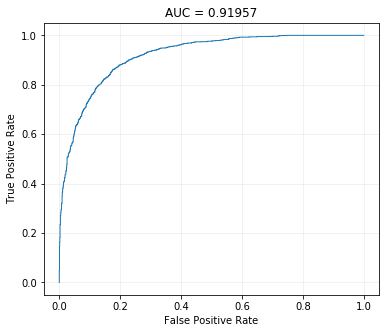

In [63]:
ROC(X_test,Y_test,classifier)

In [64]:
# Classification Metrics
accuracy  = accuracy_score(Y_test, classifier.predict(X_test))
precision = precision_score(Y_test, classifier.predict(X_test),  average="macro")
recall    = recall_score(Y_test, classifier.predict(X_test),  average="macro")
F1        = f1_score(Y_test, classifier.predict(X_test),  average="macro")

print("Accuracy = %0.4f"%accuracy)
print("Precision = %0.4f"%precision)
print("Recall = %0.4f"%recall)
print("F1 Score = %0.4f"%F1)

Accuracy = 0.8337
Precision = 0.8350
Recall = 0.8337
F1 Score = 0.8336


TN: 1416
FN: 322
TP: 1317
FP: 223


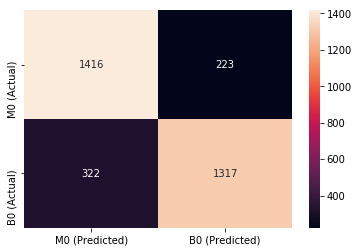

In [65]:
TN, FP, FN, TP = confusion_matrix(Y_test, classifier.predict(X_test)).ravel()
CM = confusion_matrix(Y_test, classifier.predict(X_test))
CM = pd.DataFrame(CM, index = ["M0 (Actual)","B0 (Actual)"],
                  columns = ["M0 (Predicted)","B0 (Predicted)"])
sn.heatmap(CM, annot=True, fmt='g')
print("TN: %d"%TN)
print("FN: %d"%FN)
print("TP: %d"%TP)
print("FP: %d"%FP)

## 5-Fold Cross-Validation

In [66]:
full_features_B0 = np.zeros(shape=(train_features_B0.shape[0]+val_features_B0.shape[0],train_features_B0.shape[1]))
full_features_M0 = np.zeros(shape=(train_features_M0.shape[0]+val_features_M0.shape[0],train_features_M0.shape[1]))

full_features_B0[:train_features_B0.shape[0],:] = train_features_B0
full_features_B0[train_features_B0.shape[0]:,:] = val_features_B0

full_features_M0[:train_features_M0.shape[0],:] = train_features_M0
full_features_M0[train_features_M0.shape[0]:,:] = val_features_M0

In [67]:
X, Y               = concat_and_shuffled(class0=full_features_B0, class1=full_features_M0, shuffled=True)
X                  = (X-np.mean(X,axis=0))/np.std(X,axis=0)
KFclassifier       = svm.SVC(C=10,gamma='scale',probability=True,class_weight='balanced')
scoring_metrics    = ['roc_auc', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores             = cross_validate(KFclassifier, X, Y, scoring=scoring_metrics, cv=5)

In [68]:
# Classification Metrics
print("Accuracy = %0.4f"%scores['test_accuracy'].mean())
print("Precision = %0.4f"%scores['test_precision_macro'].mean())
print("Recall = %0.4f"%scores['test_recall_macro'].mean())
print("F1 Score = %0.4f"%scores['test_f1_macro'].mean())
print("ROC(AUC) = %0.4f"%scores['test_roc_auc'].mean())

Accuracy = 0.9019
Precision = 0.9020
Recall = 0.9019
F1 Score = 0.9019
ROC(AUC) = 0.9620
